<a href="https://colab.research.google.com/github/beamvilla/LE615-IoT/blob/master/trainonresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

Using TensorFlow backend.


In [0]:
def sortdata(data_list):
    class_name = data_list[0].split('_')
    class_name = class_name[0]
    dataname = []
    list_shape = np.shape(data_list)[0]
    for ii in range(list_shape):
        name1 = data_list[ii].split('_')
        name2 = name1[1].split('.')
        name2 = int(name2[0])
        dataname.append(name2)
    dataname.sort()
    newimgname = []
    for ii in range(list_shape):
        name_im = class_name + '_'+str(dataname[ii])+'.jpg'
        newimgname.append(name_im)
    return newimgname  

In [0]:
#zip_path = '/content/drive/My Drive/dataset_lastest.zip'
#out_path = '/content/'
#import zipfile
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(out_path)

In [0]:
def createdataset(typedata):
  dataset_path = '/content/dataset_lastest/'+typedata
  classes = sorted(os.walk(dataset_path).__next__()[1])
  print(classes)
  imagepaths = []
  for c in classes:
      c_dir = os.path.join(dataset_path, c)
      walk = os.listdir(c_dir)
      walk = sortdata(walk)
      # Add each image to the training set
      for sample in walk:
          # Only keeps jpeg images
          if sample.endswith('.jpg') or sample.endswith('.jpeg'):
              imagepaths.append(os.path.join(c_dir, sample))
    
  shapedata = np.shape(imagepaths)[0]
  traindata = []
  for ii in range (shapedata):
      image = np.asarray(Image.open(imagepaths[ii]))
      traindata.append(image)
  return traindata

Import Trainning data

In [4]:
#training data
x_train = np.asarray(createdataset('train'))

['1TJ_Good', '2TJ_Bad', '3YT_Good', '4YT_Bad', '5KA_Good', '6KA_Bad', '7ETC']


In [0]:
#label training data
y_train = np.load('y_train.npy')
y_train = np.asarray(y_train)

Split training set to validation set

In [0]:
#Split training data to validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.18, random_state=16)

Convert x_train and x_val to float type

In [0]:
#x_train
x_train = x_train.astype('float32')
x_train /= 255.0


In [0]:
#x_val
x_val = x_val.astype('float32')
x_val /= 255.0

Import Test set

In [9]:
#Test data
x_test = np.asarray(createdataset('test'))

['1TJ_Good', '2TJ_Bad', '3YT_Good', '4YT_Bad', '5KA_Good', '6KA_Bad', '7ETC']


In [0]:
#label test data
y_test = np.load('y_test.npy')
y_test = np.asarray(y_test)

Covert x_test to float type

In [0]:
#x_test
x_test = x_test.astype('float32')
x_test /= 255.0

Normalize data

In [12]:
#Find RGB_mean
def findRGBmean(traindata,validdata,testdata):
  x0 = traindata[:,:,:,0]
  x1 = traindata[:,:,:,1]
  x2 = traindata[:,:,:,2]
  meanim0 = np.mean(x0)
  meanim1 = np.mean(x1)
  meanim2 = np.mean(x2)
  meanim = [meanim0,meanim1,meanim2]
  print('Mean image: ',meanim)
  #Subtract x_train with RGB Mean
  traindata[:,:,:,0] = traindata[:,:,:,0]-meanim0
  traindata[:,:,:,1] = traindata[:,:,:,1]-meanim1
  traindata[:,:,:,2] = traindata[:,:,:,2]-meanim2

  #Subtract x_val with RGB Mean
  validdata[:,:,:,0] = validdata[:,:,:,0]-meanim0
  validdata[:,:,:,1] = validdata[:,:,:,1]-meanim1
  validdata[:,:,:,2] = validdata[:,:,:,2]-meanim2

  #Subtract x_train with RGB Mean
  testdata[:,:,:,0] = testdata[:,:,:,0]-meanim0
  testdata[:,:,:,1] = testdata[:,:,:,1]-meanim1
  testdata[:,:,:,2] = testdata[:,:,:,2]-meanim2

  return traindata,validdata,testdata

def findallmean(traindata,validdata,testdata):
  meanim = np.mean(traindata,axis=(0,1,2,3))
  print('Mean image: ',meanim)
  traindata = traindata - meanim
  validdata = validdata - meanim
  testdata = testdata - meanim
  return traindata,validdata,testdata

def findRGBstd(traindata,validdata,testdata):
  x0 = traindata[:,:,:,0]
  x1 = traindata[:,:,:,1]
  x2 = traindata[:,:,:,2]
  #Mean
  meanim0 = np.mean(x0)
  meanim1 = np.mean(x1)
  meanim2 = np.mean(x2)
  meanim = [meanim0,meanim1,meanim2]
  print('Mean image: ',meanim)

  #Std
  stdim0 = np.std(x0)
  stdim1 = np.std(x1)
  stdim2 = np.std(x2)
  stdim = [stdim0,stdim1,stdim2]
  print('Std image: ',stdim)

  #Subtract and devide x_train with RGB Mean and RGB std
  traindata[:,:,:,0] = (traindata[:,:,:,0]-meanim0)/stdim0
  traindata[:,:,:,1] = (traindata[:,:,:,1]-meanim1)/stdim1
  traindata[:,:,:,2] = (traindata[:,:,:,2]-meanim2)/stdim2

  #Subtract and devide x_val with RGB Mean and RGB std
  validdata[:,:,:,0] = (validdata[:,:,:,0]-meanim0)/stdim0
  validdata[:,:,:,1] = (validdata[:,:,:,1]-meanim1)/stdim1
  validdata[:,:,:,2] = (validdata[:,:,:,2]-meanim2)/stdim2

  #Subtract and devide x_test with RGB Mean and RGB std
  testdata[:,:,:,0] = (testdata[:,:,:,0]-meanim0)/stdim0
  testdata[:,:,:,1] = (testdata[:,:,:,1]-meanim1)/stdim1
  testdata[:,:,:,2] = (testdata[:,:,:,2]-meanim2)/stdim2
  return traindata,validdata,testdata

def findallstd(traindata,validdata,testdata):
  meanim = np.mean(traindata,axis=(0,1,2,3))
  stdim = np.std(traindata,axis=(0,1,2,3))
  print('Mean image: ',meanim)
  print('Std image: ',stdim)
  traindata = (traindata - meanim)/stdim
  validdata = (validdata - meanim)/stdim
  testdata = (testdata - meanim)/stdim
  return traindata,validdata,testdata


[0.7020436, 0.6633451, 0.6229568]


In [0]:
#Find RGB mean
x_train,x_val,x_test = findRGBmean(x_train,x_val,x_test)

In [14]:
print('x_train:',x_train.shape)
print('x_val:',x_val.shape)
print('x_test:',x_test.shape)

x_train: (19516, 224, 224, 3)
x_val: (4284, 224, 224, 3)
x_test: (4200, 224, 224, 3)


Resnet50

In [0]:
#Define parameter
n_class = 7
n_epochs = 50
n_batch_size = 35
n_test = 4200
opt = keras.optimizers.RMSprop(lr=0.0001)

In [16]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

In [0]:
base_model.trainable = False
    
add_layer = GlobalAveragePooling2D()(base_model.output)
add_layer = Dense(128, activation='relu')(add_layer)
predict_layer = Dense(n_class, activation='softmax')(add_layer)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predict_layer)

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
              batch_size=n_batch_size,
              epochs=n_epochs,
              validation_data=(x_val, y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 19516 samples, validate on 4284 samples
Epoch 1/50
19516/19516 [==============================] - 158s 8ms/step - loss: 0.1782 - acc: 0.9398 - val_loss: 1.1075 - val_acc: 0.8810
Epoch 2/50
19516/19516 [==============================] - 143s 7ms/step - loss: 0.0712 - acc: 0.9772 - val_loss: 0.2075 - val_acc: 0.9638
Epoch 3/50
19516/19516 [==============================] - 142s 7ms/step - loss: 0.0476 - acc: 0.9855 - val_loss: 1.1396 - val_acc: 0.8469
Epoch 4/50
19516/19516 [==============================] - 142s 7ms/step - loss: 0.0320 - acc: 0.9900 - val_loss: 0.5962 - val_acc: 0.9136
Epoch 5/50
19516/19516 [==============================] - 142s 7ms/step - loss: 0.0256 - acc: 0.9915 - val_loss: 0.3021 - val_acc: 0.9547
Epoch 6/50
19516/19516 [==============================] - 142s 7ms/step - loss: 0.0218 - acc: 0.9930 - val_loss: 0.1700 - val_acc: 0.9676
Epoch 7/50
19516/19516 [=

In [21]:
model.save_weights("rs_1.h5")
print("Saved model to disk")

Saved model to disk


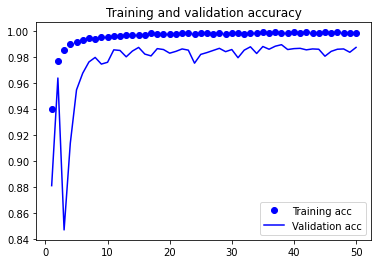

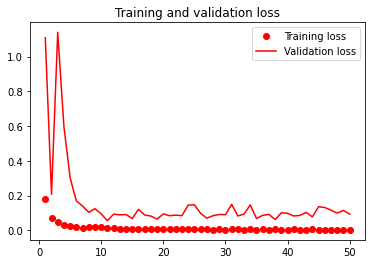

In [22]:
# Plot graphs of accuracy and losses during training. 
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
 
epochs = range(1, len(acc)+1) 
 
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
 
plt.figure() 
 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
 
plt.plot(epochs, loss, 'ro', label='Training loss') 
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
 
plt.show() 


In [23]:
# Evaluate trained model.
loss_and_metrics = model.evaluate(x_test, y_test,
                                 batch_size=n_batch_size)
print('Test loss:', loss_and_metrics[0])
print('Test accuracy:', loss_and_metrics[1])

4200/4200 [==============================] - 10s 2ms/step
Test loss: 1.1569199670381705
Test accuracy: 0.8780952430019776


In [24]:
y_pred = model.predict(x_test)
#y_t = [np.argmax(i) for i in y_test]
y_t = [np.argmax(i) for i in y_test]
y_p = [np.argmax(i) for i in y_pred]

n_each = int(n_test/n_class)

cnf_matrix = confusion_matrix(y_t,y_p)
print(cnf_matrix)

[[600   0   0   0   0   0   0]
 [225 364   0   5   0   0   6]
 [  0   0 558  42   0   0   0]
 [  0   2   0 598   0   0   0]
 [  0   0   4   0 535  61   0]
 [  0   2 122  23  20 433   0]
 [  0   0   0   0   0   0 600]]
